100%|██████████| 9.91M/9.91M [00:00<00:00, 36.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.57MB/s]


Epoch 1, Loss: 115.37
Epoch 2, Loss: 100.63
Epoch 3, Loss: 96.74
Epoch 4, Loss: 94.20
Epoch 5, Loss: 92.73
Epoch 6, Loss: 91.72
Epoch 7, Loss: 90.87
Epoch 8, Loss: 90.17
Epoch 9, Loss: 89.57
Epoch 10, Loss: 89.07


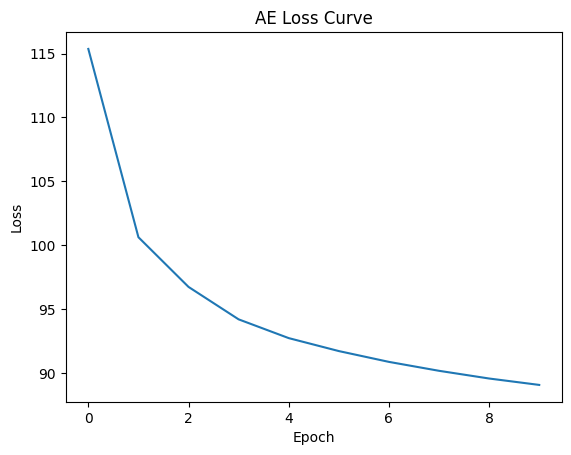

In [ ]:
#AE
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),

            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# Data loading
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
losses = []
for epoch in range(10):
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        output = model(images)
        loss = criterion(output, images.view(-1, 28*28))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.2f}")

torch.save(model.state_dict(), "ae_model.pth")

# Save loss curve
plt.plot(losses)
plt.title("AE Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.close()


Epoch 1, VAE Loss: 12365217.75
Epoch 2, VAE Loss: 10498844.45
Epoch 3, VAE Loss: 10068503.24
Epoch 4, VAE Loss: 9894737.73
Epoch 5, VAE Loss: 9797653.46
Epoch 6, VAE Loss: 9730772.15
Epoch 7, VAE Loss: 9673318.29
Epoch 8, VAE Loss: 9624479.52
Epoch 9, VAE Loss: 9578727.93
Epoch 10, VAE Loss: 9537005.05


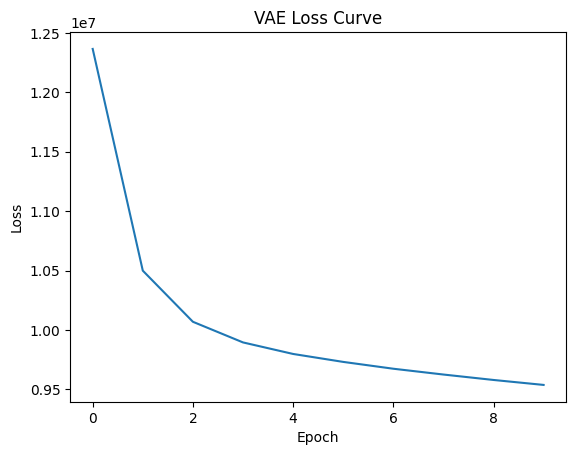

In [ ]:
#VAE
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder_fc = nn.Linear(784, 128)
        self.mu = nn.Linear(128, 2)
        self.logvar = nn.Linear(128, 2)
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 784)
        h = torch.relu(self.encoder_fc(x))
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Data loading
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
vae_losses = []
for epoch in range(10):
    epoch_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        recon_batch, mu, logvar = vae(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    vae_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, VAE Loss: {epoch_loss:.2f}")

torch.save(vae.state_dict(), "vae_model.pth")

# Save loss curve
plt.plot(vae_losses)
plt.title("VAE Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.close()


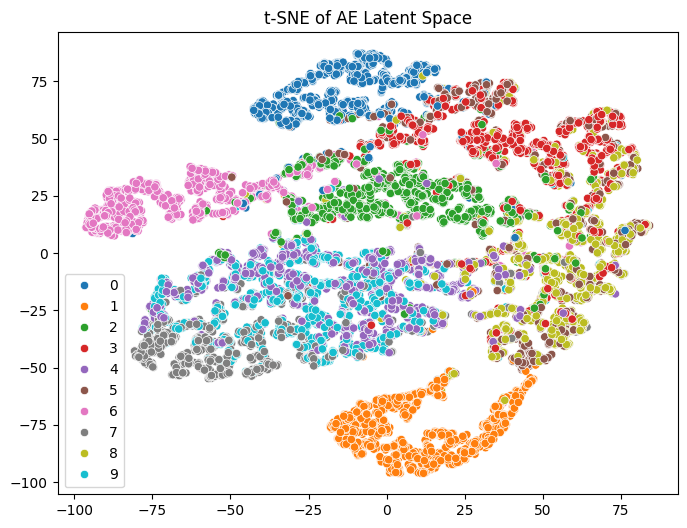

In [ ]:
#Latent Plot
from sklearn.manifold import TSNE
import seaborn as sns

latents, labels = [], []

model.eval()
with torch.no_grad():
    for images, label in test_loader:
        z = model.encoder(images.to(device))
        latents.append(z.cpu())
        labels.append(label)

z = torch.cat(latents).numpy()
y = torch.cat(labels).numpy()

tsne = TSNE(n_components=2)
z_2d = tsne.fit_transform(z)

plt.figure(figsize=(8,6))
sns.scatterplot(x=z_2d[:, 0], y=z_2d[:, 1], hue=y, palette='tab10')
plt.title("t-SNE of AE Latent Space")
plt.show()
plt.close()


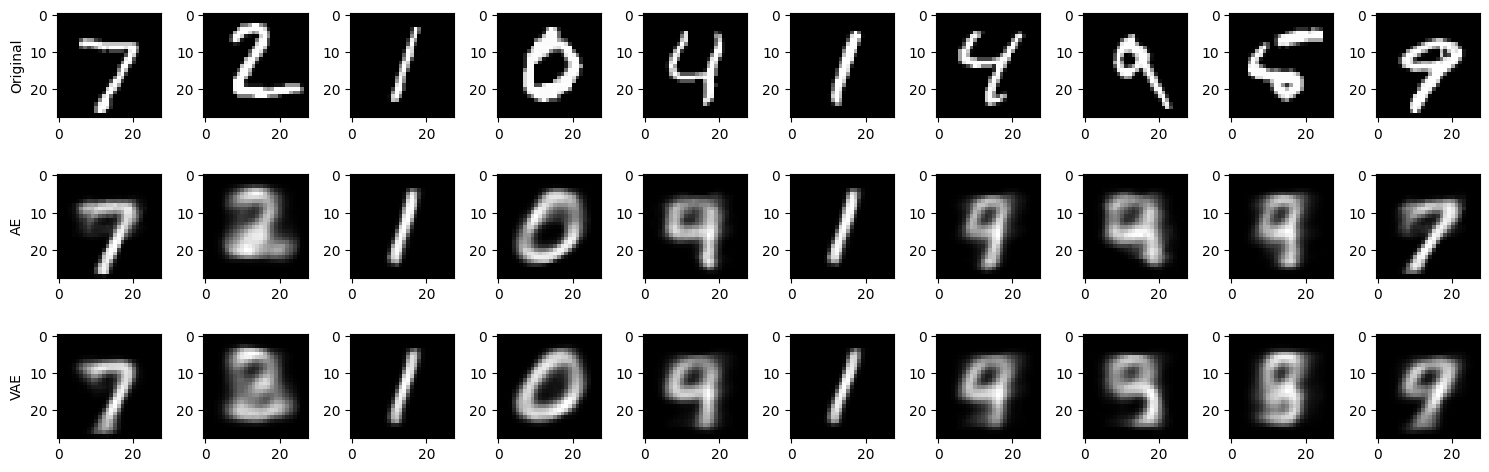

In [ ]:
#Reconstructions
model.eval()
vae.eval()

ae_recon = []
vae_recon = []
original = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        original = images[:10].cpu().numpy()
        ae_recon = model(images[:10]).cpu().numpy()
        vae_out, _, _ = vae(images[:10])
        vae_recon = vae_out.cpu().numpy()
        break

fig, axs = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(original[i][0], cmap='gray')
    axs[1, i].imshow(ae_recon[i].reshape(28, 28), cmap='gray')
    axs[2, i].imshow(vae_recon[i].reshape(28, 28), cmap='gray')
axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("AE")
axs[2, 0].set_ylabel("VAE")
plt.tight_layout()
plt.show()
plt.close()